In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats

## Clustering analysis 

### Importing the data

In [ ]:
driver = 'mysql+pymysql:'
user = 'lordchava'
password = 'xxxxxxx'
ip = '104.155.143.225'
database = 'final_project'

In [ ]:
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

Things to note of this query below:

We calculated some fields that we believe are going to give us variation between the customers. In the end,         the resultant columns that are going to be the explanatory variables for the clustering, are, number of             basket purchased, average item unit price per basket, average quantity per basket and total expenditure.


In [ ]:
query_transactions = """
SELECT "HOUSEHOLD_KEY", COUNT(DISTINCT("BASKET_ID")) AS baskets, SUM("QUANTITY") AS total_items_qty, SUM("SHELF_PRICE") / SUM("QUANTITY") as avg_unit_price, SUM("QUANTITY") /  COUNT(DISTINCT("BASKET_ID")) AS avg_qty_per_basket, SUM("CLIENT_PRICE") as total_expenditure
FROM (
  SELECT *
  FROM cluster_df_based
GROUP BY HOUSEHOLD_KEY
HAVING (total_items_qty < 4000);
"""

transactions = pd.read_sql(query_transactions, engine)

The query above is just informative. We ran the query in SEQUEL PRO and saved the results into a csv called pre_macro_cluster_df (called below)

In [3]:
cluster_df = pd.read_csv('../../data_final_project/pre_macro_cluster_df.csv').drop(['total_items_qty',],axis=1)

In [4]:
cluster_df.head()

,HOUSEHOLD_KEY,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure
0,1,14,2.782795,24.7857,805.58
1,7,6,2.873263,15.8333,228.18
2,20,5,2.400513,7.8000,75.95
3,25,17,2.854803,13.4706,534.20
4,27,41,2.335259,2.8293,260.80


### Setting the HOUSEHOLD_KEY as index

In [5]:
cluster_df.set_index('HOUSEHOLD_KEY',inplace=True)

### Checking correlations between the variables

As our objective is to perform a Cluster analysis we need to asses if our variables are highly correalted and also if we can suffer from multicollinearity. Because Kmeans is a distance-based method, highly correlated variables can produce distorted results. 

Based on this, we decided to run a correlation heatmap.

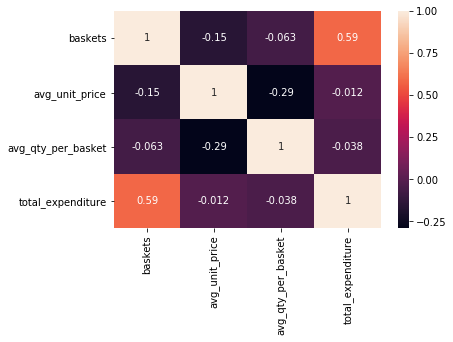

In [55]:
sns.heatmap(cluster_df.corr(), annot=True)

#### Comments:

In the correlation heatmap, we can see that the variables are not strongly correalted to one another. For our surprise, total expenditure is not highly correlated with baskets which is the number of trip a household make to the supermarket. Moreover, we decided to double check with a variance inflation factor to check for multicollinearity. 

### Checking for multicolinearity

In [56]:
from statsmodels.stats import outliers_influence
from statsmodels.tools.tools import add_constant

In [57]:
X = add_constant(cluster_df)

mc_check = pd.Series([outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
             index=X.columns)
print(mc_check)

const                 19.921856
baskets                1.592877
avg_unit_price         1.140221
avg_qty_per_basket     1.108401
total_expenditure      1.539435
dtype: float64


/Users/abreualberto91/anaconda3/envs/ironhack/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Comments:

To identify is our model could suffer from multicollinearity, we decided to not only check the correlation heatmap but to run a variance inflation factor analysis (VIF). This analysis detects multicollinearity among the variables by stimating how much the variance of a regression coefficient is inflated due to the effect of multicollinearity. The interpreation of this analysis is the follwing.

If the score is:

- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.

Based on this criteria, we can safely say that our model would not suffer from this effect. 

### Checking for relations and distributions

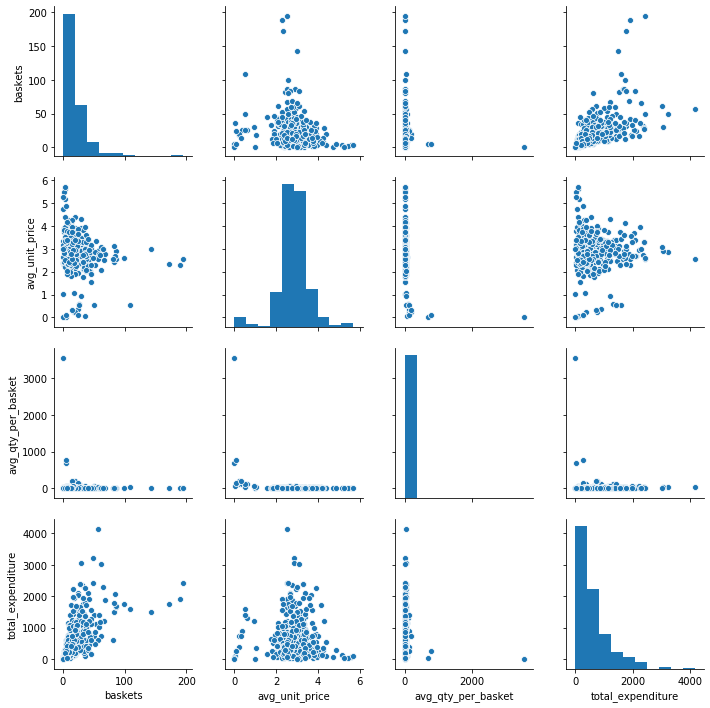

In [58]:
sns.pairplot(cluster_df)

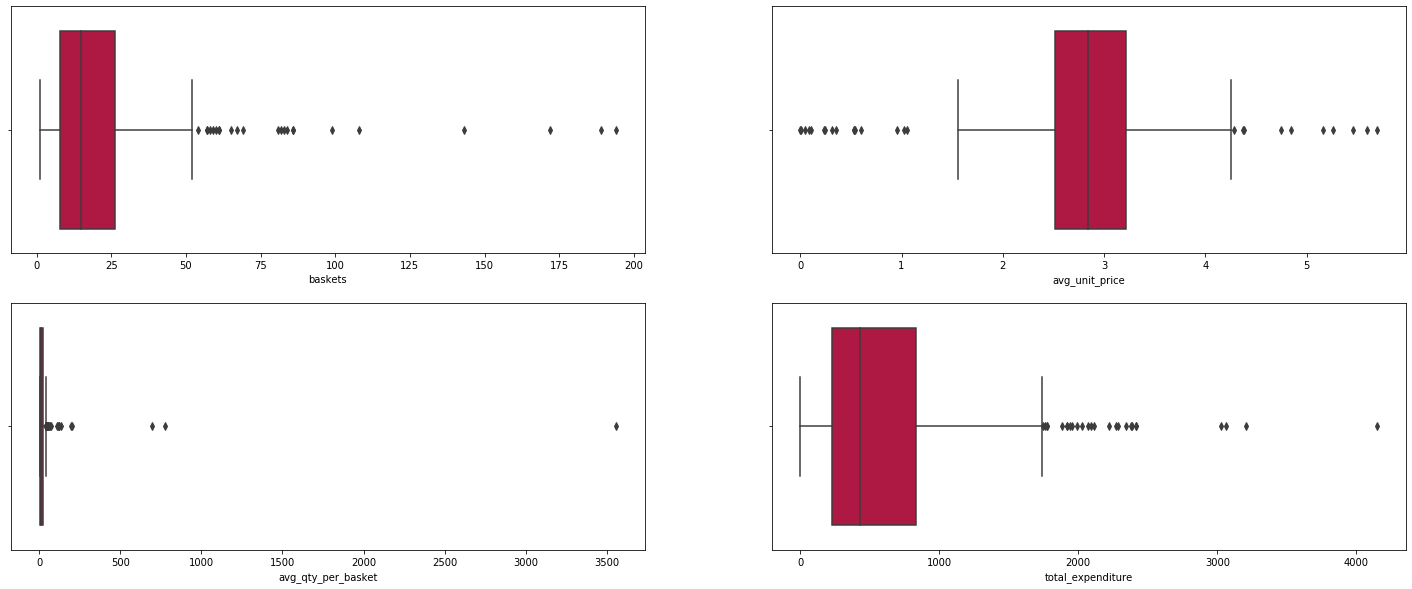

In [59]:
fig, [ax1,ax2] = plt.subplots(2,2,figsize=(25,10))

lista = ['baskets', 'avg_unit_price', 'avg_qty_per_basket','total_expenditure']

for i in range(2):
    sns.boxplot(cluster_df[lista[0+i]], ax=ax1[i], color='#C70039')
    sns.boxplot(cluster_df[lista[2+i]],ax=ax2[i],color='#C70039')

Our dataset suffers from the presence of outliers, specially in the avg_qty_per_basket were we can see that one client buys 3500 items per trip to the supermarket, we strongly believe that this in an error. Based of this assumption, we decided to remove outliers to have a cleaner data and to avoid problems when performing a clustering analysis. 

### Removing outliers

Many outliers were detected in the pairplot from above, so we decided to remove all values where z-scores are greater than 3 standard deviations. 

In [6]:
cluster_df = cluster_df[(np.abs(stats.zscore(cluster_df)) < 3).all(axis=1)]

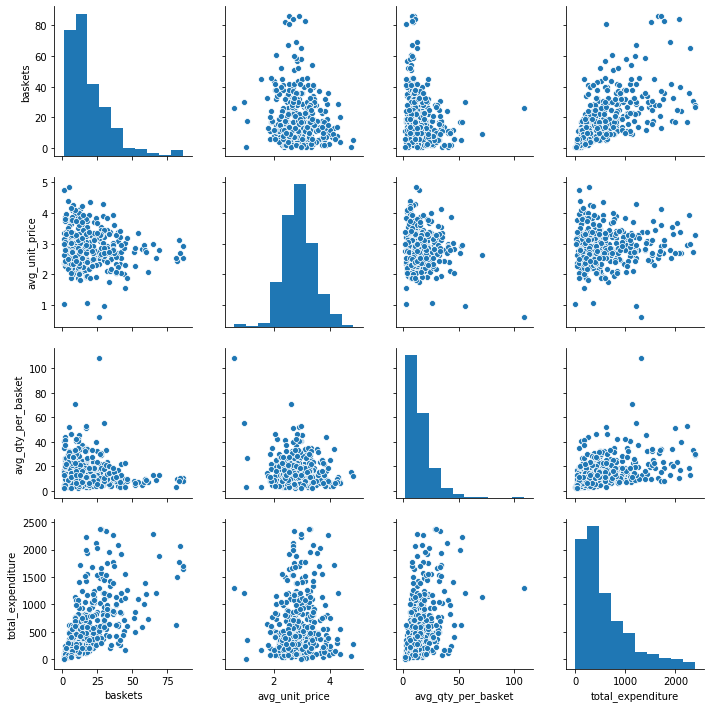

In [61]:
sns.pairplot(cluster_df)

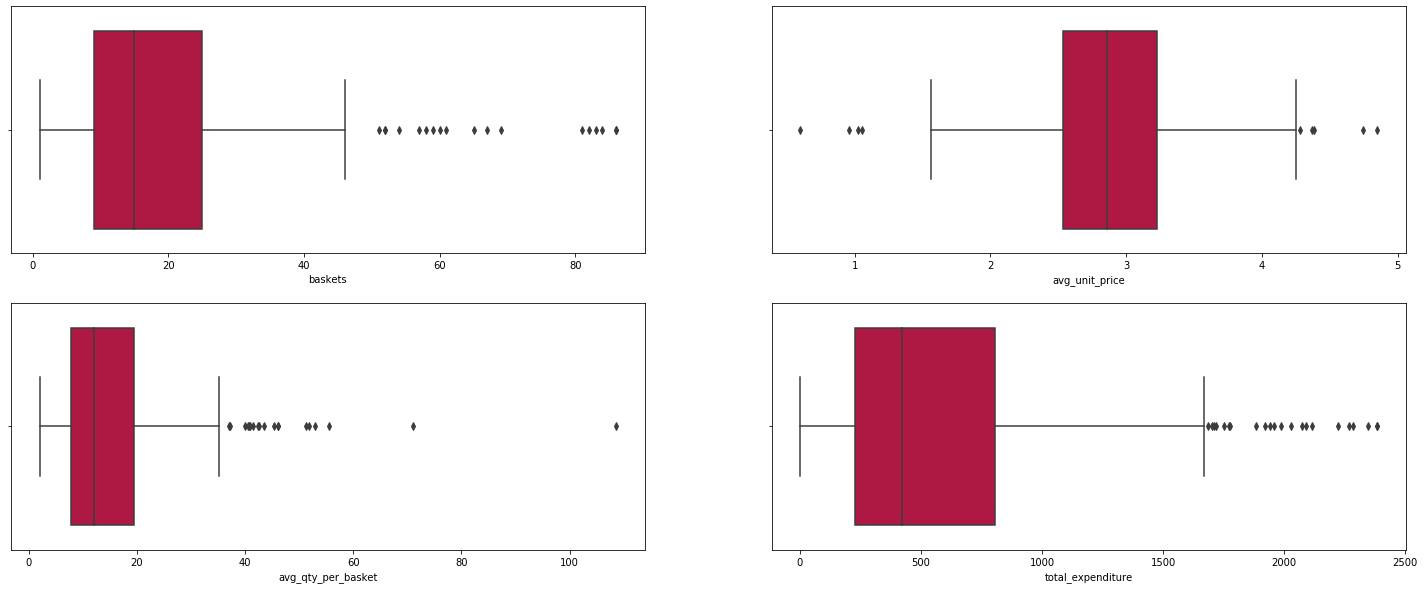

In [62]:
fig, [ax1,ax2] = plt.subplots(2,2,figsize=(25,10))

lista = ['baskets', 'avg_unit_price', 'avg_qty_per_basket','total_expenditure']

for i in range(2):
    sns.boxplot(cluster_df[lista[0+i]], ax=ax1[i], color='#C70039')
    sns.boxplot(cluster_df[lista[2+i]],ax=ax2[i],color='#C70039')

Even thou there are still some outliers, we decided to keep them as we want to identify different household segments and it is possible to find household with different purchase behaviors than others to some extent. 

### Scaling the variables for the clustering analysis

Clustering analysis requires that the variables used in the model are scaled. The main reason is that Kmeans use eucledian distances so different scales can affect the calculations of the distances, causing distortions in the results. Based on this, we decided to scaled the data using Standarization. 

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
cluster_df_scaled = scaler.transform(cluster_df)

In [9]:
cluster_df_scaled = pd.DataFrame(cluster_df_scaled)

In [10]:
cluster_df_scaled.columns = cluster_df.columns

In [11]:
cluster_df_scaled.head()

,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure
0,-0.318422,-0.191485,0.841151,0.433458
1,-0.848910,-0.031123,0.044537,-0.715735
2,-0.915221,-0.869116,-0.670292,-1.018717
3,-0.119489,-0.063844,-0.165703,-0.106667
4,1.471973,-0.984785,-1.112601,-0.650812


### Performing a Hierarchical clustering Dendogram

By performing a Hierarchical clustering we can build a dendogram or cluster tree to represent the data. This groups are organized as a tree were we can identify which ones are similar to others and which ones are different from each other. Additionaly, groups that are closer to the same hight are similar to each other and groups with different hights are different. Based on this, we can identify were to cut the tree and stimate in how many cluster we can segment our data.

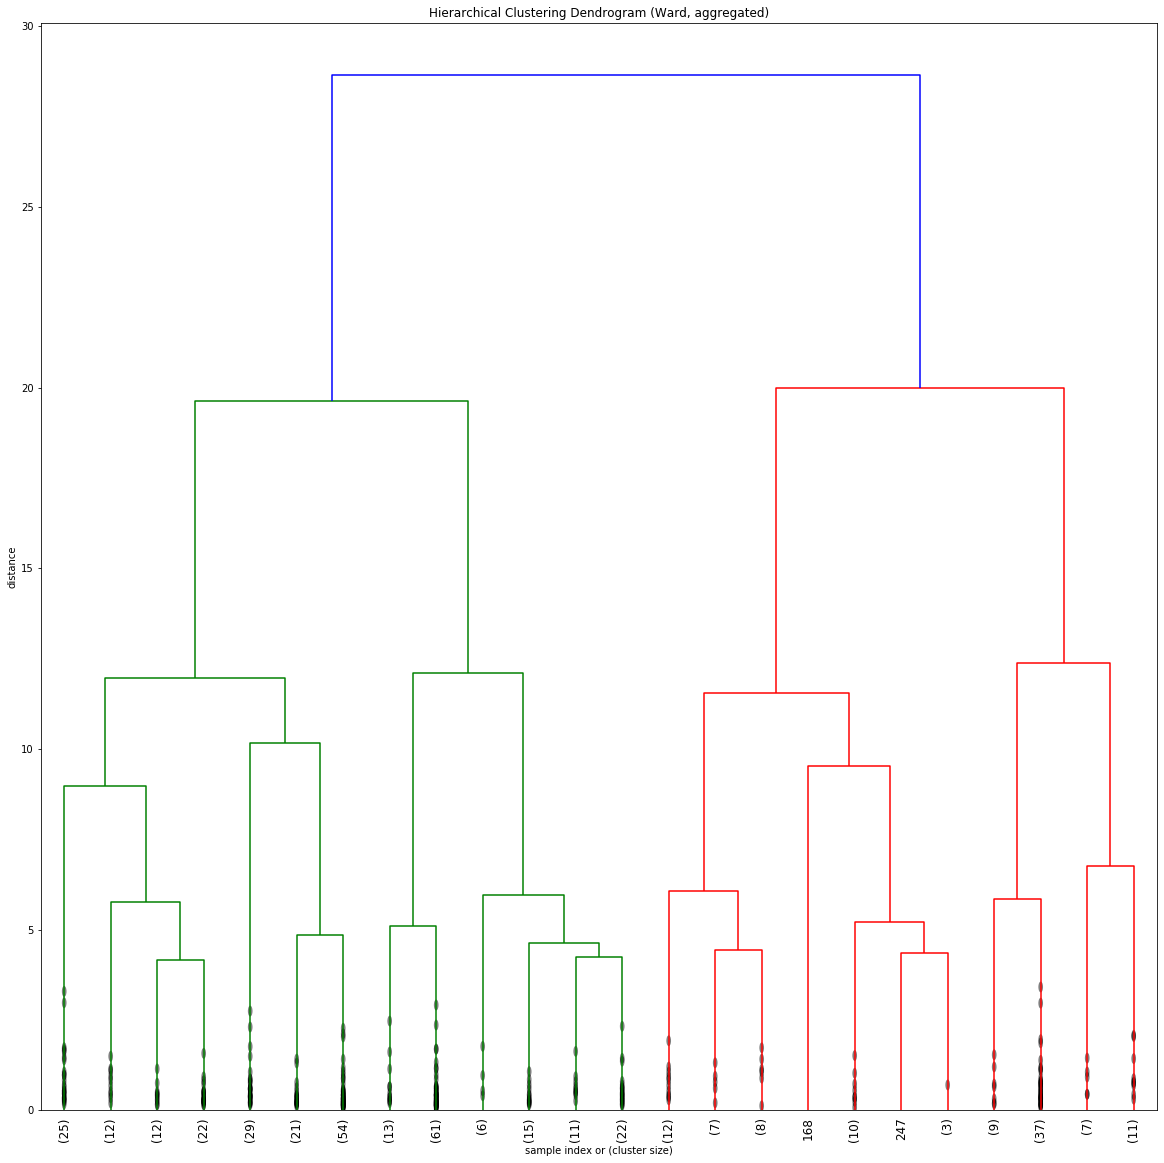

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(cluster_df_scaled, 'ward')
figure = plt.figure(figsize=(20, 20))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

### Evaluating the amount of cluster to use based on the innertia score metric

In [69]:
from sklearn.cluster import KMeans

In [70]:
clusters = []
innertia_scores = []

for i in range(1,8):
    kmeans_model = KMeans(n_clusters=i)
    kmeans_model.fit(cluster_df_scaled)
    innertia_scores.append(kmeans_model.inertia_)
    clusters.append(i)


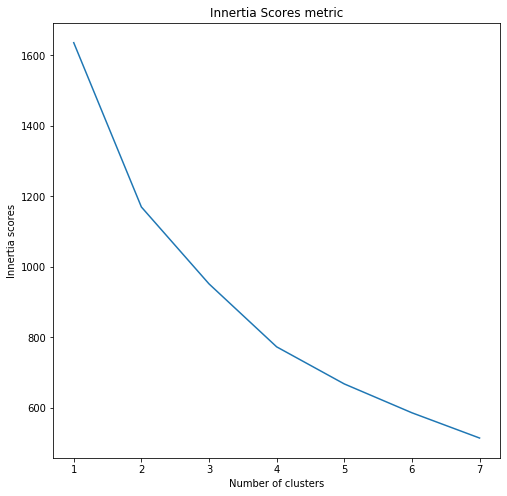

In [71]:
plt.figure(figsize=(8,8))
sns.lineplot(clusters, innertia_scores)
plt.title('Innertia Scores metric')
plt.xlabel('Number of clusters')
plt.ylabel('Innertia scores')
plt.show()

As the Kmeans model requires the number of clusters as a hyperparameter, we develop two steps to identify the best number of cluster for our analysis. The first step was to analyzed the Hierachical Clustering Dendogram to identify the distances among the ramifications. The purpose of this graph is to draw a line where the distance is greater and then count in how many clusters we can divide our data. From this analysis, the number of cluster should be 4. 

Additionally, as we are trying to separate samples in different groups of equal variance, we needed to finally decided on the number of clusters. For this step, we tried different hyperparameter and plot them in a lineplot to identify the innertia scores jumps among different models. In this graph, the x-axis is the number of clouds used as a hyperparameter in the model and as the y-axis, the innertia scores from each model. 

From this analysis, we finally decided to used 5 clusters to better identify the characteristics of the clusters. 

### KMeans clustering analysis

In [72]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(cluster_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [73]:
kmeans_model.inertia_

667.7102264047884

### Adding the column 'cluster' to our original table 'cluster_df'

In [74]:
cluster_df['cluster'] = kmeans_model.labels_

/Users/abreualberto91/anaconda3/envs/ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
cluster_df.head()

,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure,cluster
HOUSEHOLD_KEY,,,,,
1,14,2.782795,24.7857,805.58,4
7,6,2.873263,15.8333,228.18,3
20,5,2.400513,7.8000,75.95,3
25,17,2.854803,13.4706,534.20,3
27,41,2.335259,2.8293,260.80,1


### Checking the proportions of each cluster

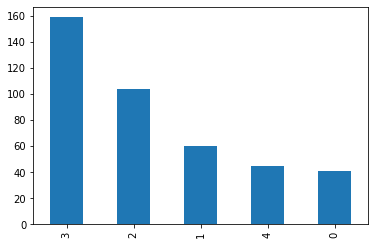

In [76]:
cluster_df['cluster'].value_counts().plot(kind='bar')

### Importing the demographics table

In [77]:
driver = 'mysql+pymysql:'
user = 'lordchava'
password = '19693903'
ip = '104.155.143.225'
database = 'final_project'

In [78]:
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [79]:
demo = pd.read_sql("demographics", engine)

### Joining the two dataframes

In [80]:
demo_cluster = cluster_df.merge(demo, how="left", on="HOUSEHOLD_KEY")

In [81]:
demo_cluster.head()

,HOUSEHOLD_KEY,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure,cluster,AGE_DESC,INCOME_DESC,ADULTS_NUM,KIDS_NUM,NUMEROUS_FAM,SINGLE_GENDER
0,1,14,2.782795,24.7857,805.58,4,65+,35-49K,2,0,0,N/A
1,7,6,2.873263,15.8333,228.18,3,45-54,50-74K,2,0,0,N/A
2,20,5,2.400513,7.8000,75.95,3,25-34,75-99K,2,0,0,N/A
3,25,17,2.854803,13.4706,534.20,3,35-44,50-74K,1,0,0,N/A
4,27,41,2.335259,2.8293,260.80,1,45-54,25-34K,1,0,0,Single Female


### Discretiziting the categorical variables

In our demographic table, we have different categorical variables that are represented in bins, for example, INCOME_DESC which indicated the range of income a household have. Based on this, we decide to discretized the categorical variables and assign them a category but in the type of an interger for better interpretation when we group by cluster labels. 

#### Ages

In this step, we assign median values to the age bins.

In [82]:
demo_cluster.AGE_DESC.value_counts()

45-54    143
35-44     93
25-34     74
65+       43
55-64     32
19-24     24
Name: AGE_DESC, dtype: int64

In [83]:
demo_cluster.loc[demo_cluster["AGE_DESC"].str.match("19-24"), "AGE_MED"] = 20
demo_cluster.loc[demo_cluster["AGE_DESC"].str.match("25-34"), "AGE_MED"] = 30
demo_cluster.loc[demo_cluster["AGE_DESC"].str.match("35-44"), "AGE_MED"] = 40
demo_cluster.loc[demo_cluster["AGE_DESC"].str.match("45-54"), "AGE_MED"] = 50
demo_cluster.loc[demo_cluster["AGE_DESC"].str.match("65+"), "AGE_MED"] = 60

#### Income

In this step, we defined five categories to the income levels.

- 1 = Lower middle class earninig less than 24K per year.
- 2 = Middle class earning between 25K and 49K per year.
- 3 = Upper middle class earninig between 50K and 74K per year.
- 4 = Lower upper class earning between 99k and 124K per year.
- 5 = Upper and richest classes earninig more than 125K per year.

In [84]:
demo_cluster.INCOME_DESC.value_counts()

50-74K       95
35-49K       86
15-24K       48
75-99K       48
25-34K       39
Under 15K    32
100-124K     16
125-149K     15
150-174K     14
250K+         6
175-199K      6
200-249K      4
Name: INCOME_DESC, dtype: int64

In [85]:
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("Under 15K"), "INCOME_LEVEL"] = 1
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("15-24K"), "INCOME_LEVEL"] = 1
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("25-34K"), "INCOME_LEVEL"] = 2
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("35-49K"), "INCOME_LEVEL"] = 2
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("50-74K"), "INCOME_LEVEL"] = 3
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("75-99K"), "INCOME_LEVEL"] = 4
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("100-124K"), "INCOME_LEVEL"] = 4
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("125-149K"), "INCOME_LEVEL"] = 5
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("150-174K"), "INCOME_LEVEL"] = 5
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("175-199K"), "INCOME_LEVEL"] = 5
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("200-249K"), "INCOME_LEVEL"] = 5
demo_cluster.loc[demo_cluster["INCOME_DESC"].str.match("250K+"), "INCOME_LEVEL"] = 5

### Single Gender

With gender, we wanted to see distinctions in purchase behavior between single females and single males. We assign 1 to females and 2 to single males. For couples and single adults with kids where the gender was not specicify, NaN values to avoid effects in the results when calculating the mean values of this two groups.

In [86]:
demo_cluster.SINGLE_GENDER.value_counts()

N/A              279
Single Female     79
Single Male       51
Name: SINGLE_GENDER, dtype: int64

In [87]:
demo_cluster.loc[demo_cluster["SINGLE_GENDER"].str.match("N/A"), "GENDER_CAT"] = np.nan
demo_cluster.loc[demo_cluster["SINGLE_GENDER"].str.match("Single Female"), "GENDER_CAT"] = 1
demo_cluster.loc[demo_cluster["SINGLE_GENDER"].str.match("Single Male"), "GENDER_CAT"] = 2

In [88]:
demo_cluster.head()

,HOUSEHOLD_KEY,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure,cluster,AGE_DESC,INCOME_DESC,ADULTS_NUM,KIDS_NUM,NUMEROUS_FAM,SINGLE_GENDER,AGE_MED,INCOME_LEVEL,GENDER_CAT
0,1,14,2.782795,24.7857,805.58,4,65+,35-49K,2,0,0,N/A,60.0,2.0,NaN
1,7,6,2.873263,15.8333,228.18,3,45-54,50-74K,2,0,0,N/A,50.0,3.0,NaN
2,20,5,2.400513,7.8000,75.95,3,25-34,75-99K,2,0,0,N/A,30.0,4.0,NaN
3,25,17,2.854803,13.4706,534.20,3,35-44,50-74K,1,0,0,N/A,40.0,3.0,NaN
4,27,41,2.335259,2.8293,260.80,1,45-54,25-34K,1,0,0,Single Female,50.0,2.0,1.0


In [41]:
demo_cluster.to_csv('../../data_final_project/macro_cluster_df.csv', index=False)

## Identifying cluster characteristics

In this step, we want to see what variables differentiate one cluster from another by grouping by cluster label and checking the mean values. This step is critical to identify the purchase behavior of each cluster so we can dig deeper in the ones that are really interesting for the retailer. 

In [89]:
demo_cluster.groupby('cluster').mean().style.background_gradient(cmap='viridis')

,HOUSEHOLD_KEY,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure,ADULTS_NUM,KIDS_NUM,NUMEROUS_FAM,AGE_MED,INCOME_LEVEL,GENDER_CAT
cluster,,,,,,,,,,,
0,1202.76,27.8537,3.09104,24.571,1646.58,1.73171,0.731707,0.170732,42.2222,3.19512,1.33333
1,1128.88,45.4,2.63603,9.3361,885.407,1.53333,0.616667,0.116667,43.5849,2.35,1.55
2,1279.98,13.75,3.53156,10.9416,412.999,1.61538,0.298077,0.0384615,42.7273,2.76923,1.38889
3,1179.63,12.4843,2.58261,12.0725,303.677,1.62893,0.584906,0.100629,43.3103,2.55346,1.34
4,1146.84,9.08889,2.65631,36.5797,634.154,1.73333,0.755556,0.133333,41.1364,2.88889,1.4


In [90]:
demo_cluster_aggr = demo_cluster.groupby('cluster').mean()

In [92]:
demo_cluster_aggr = demo_cluster_aggr[['baskets','avg_unit_price','avg_qty_per_basket','total_expenditure','INCOME_LEVEL','KIDS_NUM' ]]

In [93]:
demo_cluster_aggr.style.background_gradient(cmap='viridis')

,baskets,avg_unit_price,avg_qty_per_basket,total_expenditure,INCOME_LEVEL,KIDS_NUM
cluster,,,,,,
0,27.8537,3.09104,24.571,1646.58,3.19512,0.731707
1,45.4,2.63603,9.3361,885.407,2.35,0.616667
2,13.75,3.53156,10.9416,412.999,2.76923,0.298077
3,12.4843,2.58261,12.0725,303.677,2.55346,0.584906
4,9.08889,2.65631,36.5797,634.154,2.88889,0.755556


### Commenting the results:

Characteristics of each cluster:

**Cluster 0:** This group of customers go to the supermarket in a medium-regular basis, buying good quality products and filling up the shopping card with many items. Also they are the ones who spent more money in total representing around 10% of our customer base. In terms of demographics, they are the ones with the highest income level.

**Cluster 1:** The customers belonging to this segment are the ones who visit the supermarket the most, around 45 times per week but they buy few products in every visit. Their average income level puts them in last place so we can infer that they are restricted when it comes to filling up the shopping car in one trip, buying products as the week goes. 

**Cluster 2:** The main differences with this segment is that they buy on average pricier products than the rest of segments. Also, it seems that this group belong to singles adults as the number of kids in close to cero. 

**Cluster 3:** This group seems to be the middle group where they do not come often to the supermarket, do not buy pricier products making them the last group in total expenditures.

**Cluster 4:** This group is very interesting as they do not come very often but when they do, they tend to fill up the shopping car with many items (around 36 items per basket). Moreover, they rank in second place in income level and fist in number of kids. This differences makes them an strategical group for our analysis as they can be moved into potential clients if the marketing campaing are targeted to them in an optimal way. For this reason, we decided to look deeper into the purchase behavior regarding the categories of items purchased to detect their needs and the reason of their visits to the supermarket. 



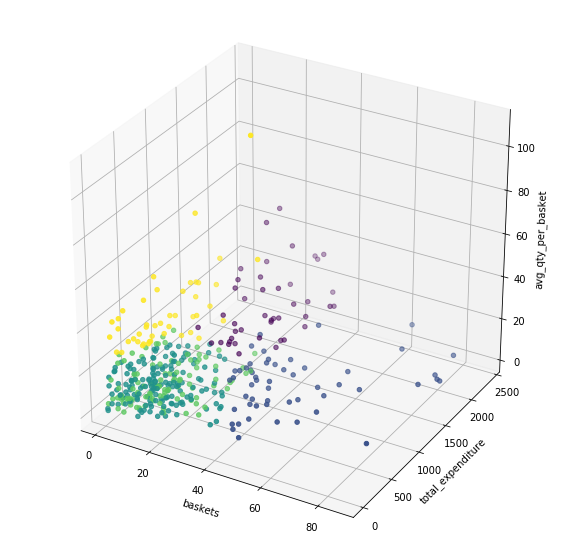

In [40]:
from mpl_toolkits.mplot3d import Axes3D
# Setting the figure and creating a 3d subplot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3 variables: weight, height and gender, stratified by label 
ax.scatter(demo_cluster['baskets'], demo_cluster['total_expenditure'], demo_cluster['avg_qty_per_basket'], c= demo_cluster['cluster'])

# Setting aesthetics for patients figure 

ax.set_xlabel("baskets")
ax.set_ylabel("total_expenditure")
ax.set_zlabel("avg_qty_per_basket")

plt.show() 

#### Comments on the graph:

In this 3D graph we plot three of the variables used in the Kmeans clustering model to visualy undertand the differences among the clusters. Cluster 0 and 1 are more similar than the rest, they are represented by the color purple (cluster 0) and my color blue (cluster 1). As we mentioned above, this groups are the ones who total expenditures are greater than the other groups. Also, the selected strategical group, cluster number 4 is represented with the color yellow. 